In [1]:
from phidl import quickplot as qp
import scipy.integrate as integrate
import phidl.geometry as pg
import sys
import os
from phidl import Device, Layer, LayerSet, device_layout, Path, CrossSection
import phidl.routing as pr
import phidl.utilities as pu
import phidl.path as pp
import numpy as np

ls = LayerSet()
ls.add_layer(name = 'label', gds_layer = 1, gds_datatype = 0,
             description = 'General label', color = 'deeppink')
ls.add_layer(name = 'marker', gds_layer = 2, gds_datatype = 0,
             description = 'EBL marker', color = 'firebrick')
ls.add_layer(name = 'grating', gds_layer = 3, gds_datatype = 0,
             description = 'bragg_grating', color = 'darkturquoise')
ls.add_layer(name = 'wg', gds_layer = 4, gds_datatype = 0,
             description = 'LN wg', color = 'dodgerblue')
ls.add_layer(name = 'ring', gds_layer = 5, gds_datatype = 0,
             description = 'LN ring', color = 'deepskyblue')
ls.add_layer(name = 'gold1', gds_layer = 6, gds_datatype = 0,
             description = 'Gold electrode', color = 'gold')
ls.add_layer(name = 'via', gds_layer = 7, gds_datatype = 0,
             description = 'hole', color = 'grey')
ls.add_layer(name = 'gold2', gds_layer = 8, gds_datatype = 0,
             description = '2nd Gold electrode', color = 'goldenrod')
ls.add_layer(name = 'nicr', gds_layer = 9, gds_datatype = 0,
             description = 'heater', color = (0.4,0.5,0.7))
ls.add_layer(name = 'test', gds_layer = 10, gds_datatype = 0,
             description = 'alignment', color = 'lime')
ls.add_layer(name = 'mc', gds_layer = 11, gds_datatype = 0,
             description = 'mode converter', color = 'mediumblue')
ls.add_layer(name = 'detch', gds_layer = 12, gds_datatype = 0,
             description = 'deep etch', color = 'orangered')

pu.write_lyp('my_layer_properties_file.lyp', layerset = ls)

layer_label =  ls['label']
layer_marker = ls['marker']
layer_grating = ls['grating']
layer_wg = ls['wg']
layer_ring = ls['ring']
layer_metal = ls['gold1']
layer_via = ls['via']
layer_metal2 = ls['gold2']
layer_heater = ls['nicr']
layer_test = ls['test']
layer_MC = ls['mc']
layer_Detch = ls['detch']

ModuleNotFoundError: No module named 'scipy'

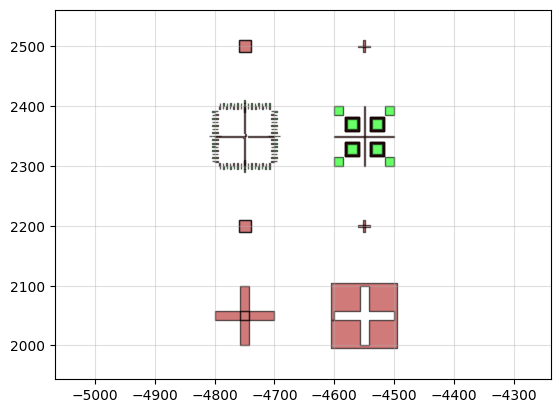

In [3]:
# building blocks

pg.compass(size=(100, 50), layer=0)

# arbitrary sin curve
def s_bend(width1 = 1, width2 = 3, offset = 50, length = 100, layer = layer_wg):
    D = Device()
    X1 = CrossSection()
    X1.add(width = width1, offset = 0, layer = layer, name = 'wg1')
    X2 = CrossSection()
    X2.add(width = width2, offset = -offset, layer = layer, name = 'wg1')
    Xtrans = pp.transition(cross_section1 = X1,cross_section2 = X2, width_type = 'sine')
    P3 = Path().append(pp.straight(length = length))
    D = P3.extrude(Xtrans)
    D.add_port(name = 'o1', midpoint = [0,0], width = width1, orientation = 180)
    D.add_port(name = 'o2', midpoint = [length,offset], width = width2, orientation = 0)
    return D

def bend(radius = 50, orientation=-1, width=2, layer = layer_wg):
    D = Device()
    D << Path().append(pp.euler(radius=radius, angle=orientation*90, use_eff=True)).extrude(width, layer)
    D.add_port(name = "o1", midpoint = [0,0], width = width, orientation = -180)
    D.add_port(name = "o2", midpoint = [radius,orientation*radius], width = width, orientation = orientation*90)
    return D

def straight(width=3, layer = layer_wg, length=100):
    D = Device()
    D << Path().append(pp.straight(length=length)).extrude(width, layer)
    D.add_port(name = "o1", midpoint = [0,0], width = width, orientation = -180)
    D.add_port(name = "o2", midpoint = [length, 0], width = width, orientation = 0)
    return D

def taper(length=200, width1=3, width2=5, layer=layer_wg):
    D = Device()
    t = D << pg.taper(length=length, width1=width1, width2=width2, layer=layer)
    D.add_port(name = "o1", port=t.ports[1])
    D.add_port(name = "o2", port=t.ports[2])
    return D

def y_splitter(width=3, layer = layer_wg, length=100, pitch=150):
    D = Device()
    t = D << taper(length=length/2, width1=width, width2=width*2, layer=layer)
    D.add_port(name = "o1", port=t.ports['o1'])
    
    sbd1 = D << s_bend(width1 = width, width2 = width, offset = pitch/2-width/2, length = length/2, layer = layer_wg)
    sbd1.move([length/2, width/2])
    D.add_port(name = "o2", port=sbd1.ports['o2'])

    sbd2 = D << s_bend(width1 = width, width2 = width, offset = -pitch/2+width/2, length = length/2, layer = layer_wg)
    sbd2.move([length/2, -width/2])
    D.add_port(name = "o3", port=sbd2.ports['o2'])

    return D

def die():
    D = Device()
    # 8990 by 3990
    D << pg.import_gds('marker.gds', flatten=True)
    #D << pg.rectangle(size=())
    return D

def heater(width=3, length=500):
    D = Device()

    str = D << straight(width=width, layer = layer_wg, length=length+200).move([-100,0])
    D.add_port(name = "o1", port=str.ports['o1'])
    D.add_port(name = "o2", port=str.ports['o2'])

    heat = D << straight(width=7, layer = layer_heater, length=length)

    com1 = D << pg.compass(size=(50, 50), layer=layer_heater).move([-50, 0])
    com2 = D << pg.compass(size=(50, 50), layer=layer_heater).move([length+50, 0])

    pad1 = D << pg.compass(size=(70, 70), layer=layer_metal).move([-50, 0])
    t1 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t1.connect("o1", destination=pad1.ports['N'])
    D.add_port(name = "e11", port=t1.ports['o2'])
    t2 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t2.connect("o1", destination=pad1.ports['W'])
    D.add_port(name = "e12", port=t2.ports['o2'])
    t3 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t3.connect("o1", destination=pad1.ports['S'])
    D.add_port(name = "e13", port=t3.ports['o2'])

    pad2 = D << pg.compass(size=(70, 70), layer=layer_metal).move([length+50, 0])
    t1 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t1.connect("o1", destination=pad2.ports['N'])
    D.add_port(name = "e21", port=t1.ports['o2'])
    t2 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t2.connect("o1", destination=pad2.ports['E'])
    D.add_port(name = "e22", port=t2.ports['o2'])
    t3 = D << taper(length=10, width1=70, width2=20, layer=layer_metal)
    t3.connect("o1", destination=pad2.ports['S'])
    D.add_port(name = "e23", port=t3.ports['o2'])

    D << pr.route_quad(heat.ports['o1'], com1.ports['E'], layer = layer_heater)
    D << pr.route_quad(heat.ports['o2'], com2.ports['W'], layer = layer_heater)
    return D

def t_segment(width = 0.5, length = 45, height = 7):
    D = Device()
    D << straight(width=width, layer = layer_metal, length=length)
    ter2 = D << straight(width=width, layer = layer_metal, length=height-width)
    ter2.rotate(-90).move([length/2, -width/2])
    D.add_port(name = "o1", port=ter2.ports['o2'])
    return D

def gsg_metal_wg(gwidth = 150, swidth = 50, wg_width = 2, length = 1000, gap = 3.7):
    D = Device()

    D << straight(width=gwidth, layer = layer_metal, length=length)

    s = D << straight(width=swidth, layer = layer_metal, length=length)
    s.move([0, -(gwidth+swidth)/2-gap-2*7])
    D.add_port(name = "es1", port=s.ports['o1'])
    D.add_port(name = "es2", port=s.ports['o2'])

    g2 = D << straight(width=gwidth, layer = layer_metal, length=length)
    g2.move([0, -gwidth-gap-2*7-swidth-gap-2*7])

    wg1 = D << straight(width=wg_width, layer = layer_wg, length=length)
    wg1.move([0, -gwidth/2-7-gap/2])
    D.add_port(name = "o1", port=wg1.ports['o1'])
    D.add_port(name = "o4", port=wg1.ports['o2'])

    wg2 = D << straight(width=wg_width, layer = layer_wg, length=length)
    wg2.move([0, -gwidth/2-swidth-gap-2*7-7-gap/2])
    D.add_port(name = "o2", port=wg2.ports['o1'])
    D.add_port(name = "o3", port=wg2.ports['o2'])

    i = 0
    while i < length/50:
        t_seg = D << t_segment(width = 0.5, length = 45, height = 7)
        t_seg.rotate(180).move([50+i*50,0.25-gwidth/2-7])

        t_seg = D << t_segment(width = 0.5, length = 45, height = 7)
        t_seg.rotate(180).move([50+i*50,0.25-gwidth/2-7-gap-2*7-swidth])

        t_seg = D << t_segment(width = 0.5, length = 45, height = 7)
        t_seg.rotate(0).move([5+i*50,-gwidth/2-gap-7-0.25])

        t_seg = D << t_segment(width = 0.5, length = 45, height = 7)
        t_seg.rotate(0).move([5+i*50,-gwidth/2-gap-7-0.25-gap-2*7-swidth])

        i += 1
    
    D.add_port(name = "egb1", midpoint = [0, -3.7], width = 150, orientation = -180)
    D.add_port(name = "egb2", midpoint = [0, 3.7-gwidth-gap-2*7-swidth-gap-2*7], width = 150, orientation = -180)

    D.add_port(name = "egb3", midpoint = [length, -3.7], width = 150, orientation = 0)
    D.add_port(name = "egb4", midpoint = [length, 3.7-gwidth-gap-2*7-swidth-gap-2*7], width = 150, orientation = 0)

    return D

def gsg_metal_wg_open(gwidth = 150, swidth = 50, wg_width = 2, length = 1000, gap = 3.7):
    D = Device()
    main = D << gsg_metal_wg(gwidth = gwidth, swidth = swidth, wg_width = wg_width, length = length, gap = gap)
    D.add_port(name = "o1", port=main.ports['o1'])
    D.add_port(name = "o2", port=main.ports['o2'])
    D.add_port(name = "o3", port=main.ports['o3'])
    D.add_port(name = "o4", port=main.ports['o4'])

    g1 = D << pg.compass(size=(100, 150), layer=layer_metal)
    g1.move([-50-35, 0+7.3+43])
    D << pr.route_quad(g1.ports['E'], main.ports['egb1'], layer = layer_metal)
    D.add_port(name = "e1", port=g1.ports['W'])

    s1 = D << pg.compass(size=(100, 100), layer=layer_metal)
    s1.move([-50-35, -(gwidth+swidth)/2-gap-2*7])
    D << pr.route_quad(s1.ports['E'], main.ports['es1'], layer = layer_metal)
    D.add_port(name = "e2", port=s1.ports['W'])

    g2 = D << pg.compass(size=(100, 150), layer=layer_metal)
    g2.move([-50-35, -gwidth-gap-2*7-swidth-gap-2*7-7.3-43])
    D << pr.route_quad(g2.ports['E'], main.ports['egb2'], layer = layer_metal)
    D.add_port(name = "e3", port=g2.ports['W'])

    g3 = D << pg.compass(size=(100, 150), layer=layer_metal)
    g3.move([50+length+35, 0+7.3+43])
    D << pr.route_quad(g3.ports['W'], main.ports['egb3'], layer = layer_metal)
    D.add_port(name = "e4", port=g3.ports['E'])

    s2 = D << pg.compass(size=(100, 100), layer=layer_metal)
    s2.move([50+length+35, -(gwidth+swidth)/2-gap-2*7])
    D << pr.route_quad(s2.ports['W'], main.ports['es2'], layer = layer_metal)
    D.add_port(name = "e5", port=s2.ports['E'])

    g4 = D << pg.compass(size=(100, 150), layer=layer_metal)
    g4.move([50+length+35, -gwidth-gap-2*7-swidth-gap-2*7-7.3-43])
    D << pr.route_quad(g4.ports['W'], main.ports['egb4'], layer = layer_metal)
    D.add_port(name = "e6", port=g4.ports['E'])

    return D

def gsg_metal_wg_term(gwidth = 150, swidth = 50, wg_width = 2, length = 1000, gap = 3.7):
    D = Device()
    
    return D

def odac():
    return

def dc(gap = 1, cp_length = 100, width = 3, pitch = 50):
    D = Device()

    bd1 = D << s_bend(width1 = width, width2 = width, offset = -(pitch-width-gap)/2, length = 100, layer = layer_wg)
    D.add_port(name = "o1", port=bd1.ports['o1'])

    str1 = D << straight(width = width, layer = layer_wg, length=cp_length)
    str1.connect('o1', destination=bd1.ports['o2'])

    str2 = D << straight(width = width, layer = layer_wg, length=cp_length)
    str2.move([100, -(pitch-width-gap)/2-width-gap])

    bd2 = D << s_bend(width1 = width, width2 = width, offset = (pitch-width-gap)/2, length = 100, layer = layer_wg)
    bd2.connect('o1', destination=str1.ports['o2'])
    D.add_port(name = "o4", port=bd2.ports['o2'])

    bd3 = D << s_bend(width1 = width, width2 = width, offset = (pitch-width-gap)/2, length = 100, layer = layer_wg)
    bd3.connect('o2', destination=str2.ports['o1'])
    D.add_port(name = "o2", port=bd3.ports['o1'])

    bd4 = D << s_bend(width1 = width, width2 = width, offset = -(pitch-width-gap)/2, length = 100, layer = layer_wg)
    bd4.connect('o1', destination=str2.ports['o2'])
    D.add_port(name = "o3", port=bd4.ports['o2'])

    return D

pg.marker().write_gds("test.gds")
qp(die())

In [ ]:
#EBL markers
marker_dice_x = chip_sizex/2-1500
marker_dice_y = chip_sizey/2-facet_length1/2

marker1_x = 14500
marker1_y = 2500
marker2_x = marker1_x - 200
marker2_y = marker1_y - 150

marker3_y = marker2_y - 150
marker4_y = marker3_y - 150
marker5_y = marker1_y + 150

D13.add_ref(marker_dice_array(marker_x = chip_sizex/2, marker_y = chip_sizey/2, layer = layer_marker))
D13.add_ref(marker_dice_array(marker_x = marker_dice_x, marker_y = marker_dice_y, layer = layer_marker))
D.add_ref(D13)

D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker1_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker1_y,arm_length = 15, arm_width = 30, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker3_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker3_y,arm_length = 15, arm_width = 30, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker4_y,arm_length = 50, arm_width = 10, layer = layer_marker))
D12.add_ref(inv_marker1_array(marker_x = marker2_x, marker_y = marker4_y,arm_length = 40, arm_width = 10, layer = layer_marker))

D12.add_ref(calipermarker_array(marker_x = marker1_x, marker_y = marker2_y, arm_length = 50, arm_width=2, num_notches=7, layer1= layer_marker, layer2=layer_test))
D12.add_ref(DLalignmarker_array(marker_x = marker2_x, marker_y = marker2_y, arm_length = 40, layer1= layer_marker, layer2=layer_test))
# D12.move([1000,0])
D.add_ref(D12)

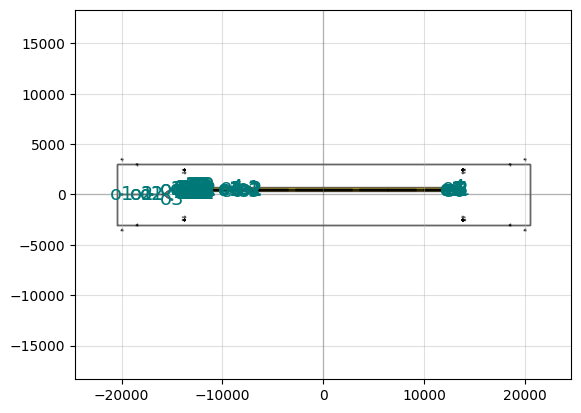

In [116]:
D = Device()

D << die4cm()
str = D << straight(width=3, layer = layer_wg, length=2000)
str.move([-20000, 0])
tp = D << taper(length=1000, width1=3, width2=0.8, layer=layer_wg)
tp.connect('o1', destination=str.ports['o2'])
ys = D << y_splitter(width=0.8, layer = layer_wg, length=2000, pitch=1000)
ys.connect('o1', destination=tp.ports['o2'])

str = D << straight(width=0.8, layer = layer_wg, length=1000)
str.connect('o1', destination=ys.ports['o2'])
ys1 = D << y_splitter(width=0.8, layer = layer_wg, length=200, pitch=67.7)
ys1.connect('o1', destination=str.ports['o2'])
tp1 = D << taper(length=500, width1=0.8, width2=2, layer=layer_wg)
tp1.connect('o1', destination=ys1.ports['o3'])
bd1 = D << bend(radius = 150, orientation=-1, width=2, layer = layer_wg)
bd1.connect('o1', destination=tp1.ports['o2'])
bd = D << bend(radius = 150, orientation=1, width=2, layer = layer_wg)
bd.connect('o1', destination=bd1.ports['o2'])
heater2 = D << heater(width=2, length=300)
heater2.connect('o1', destination=bd.ports['o2'])
bd1 = D << bend(radius = 150, orientation=1, width=2, layer = layer_wg)
bd1.connect('o1', destination=heater2.ports['o2'])
bd = D << bend(radius = 150, orientation=-1, width=2, layer = layer_wg)
bd.connect('o1', destination=bd1.ports['o2'])
str = D << straight(width=2, layer = layer_wg, length=500)
str.connect('o1', destination=bd.ports['o2'])

tp = D << taper(length=500, width1=0.8, width2=2, layer=layer_wg)
tp.connect('o1', destination=ys1.ports['o2'])
bd = D << bend(radius = 150, orientation=1, width=2, layer = layer_wg)
bd.connect('o1', destination=tp.ports['o2'])
str = D << straight(width=2, layer = layer_wg, length=50)
str.connect('o1', destination=bd.ports['o2'])
bd = D << bend(radius = 150, orientation=-1, width=2, layer = layer_wg)
bd.connect('o1', destination=str.ports['o2'])
heater1 = D << heater(width=2, length=300)
heater1.connect('o1', destination=bd.ports['o2'])
bd = D << bend(radius = 150, orientation=-1, width=2, layer = layer_wg)
bd.connect('o1', destination=heater1.ports['o2'])
str = D << straight(width=2, layer = layer_wg, length=50)
str.connect('o1', destination=bd.ports['o2'])
bd = D << bend(radius = 150, orientation=1, width=2, layer = layer_wg)
bd.connect('o1', destination=str.ports['o2'])

str = D << straight(width=2, layer = layer_wg, length=500)
str.connect('o1', destination=bd.ports['o2'])
elec1 = D << gsg_metal_wg_open(gwidth = 150, swidth = 50, wg_width = 2, length = 50 * 50, gap = 3.7)
elec1.connect('o1', destination=str.ports['o2'])
str = D << straight(width=2, layer = layer_wg, length=2000)
str.connect('o1', destination=elec1.ports['o3'])
str = D << straight(width=2, layer = layer_wg, length=2000)
str.connect('o1', destination=elec1.ports['o4'])
elec2 = D << gsg_metal_wg_open(gwidth = 150, swidth = 50, wg_width = 2, length = 50 * 50 * 8, gap = 3.7)
elec2.connect('o1', destination=str.ports['o2'])
tp = D << taper(length=500, width1=2, width2=0.8, layer=layer_wg)
tp.connect('o1', destination=elec2.ports['o3'])
tp = D << taper(length=500, width1=2, width2=0.8, layer=layer_wg)
tp.connect('o1', destination=elec2.ports['o4'])
ys1 = D << y_splitter(width=0.8, layer = layer_wg, length=200, pitch=67.7)
ys1.connect('o3', destination=tp.ports['o2'])



D.write_gds("test.gds")
qp(D)

In [ ]:
D = chip
D.write_gds("test.gds")
qp(D)